In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
# Loading CSV data, cleaning, and removing unneeded columns

# Load data
pd.set_option('display.max_columns', None)
recipes = pd.read_csv('dataset/recipeData.csv',
                      index_col='BeerID', encoding='latin1')

# Remove data with wrong scale, or excessive values
recipes = recipes[recipes['SugarScale'] == "Specific Gravity"]
recipes = recipes[recipes['OG'] <= 1.200]
recipes = recipes[recipes['OG'] >= 1.005]
recipes = recipes[recipes['ABV'] >= 2.5]

# Combine similar styles with different names/IDs
# Combine Weissbier and Weizen/Weissbier Styles
recipes.loc[recipes['StyleID'] == 169, 'Style'] = "Weizen/Weissbier"
recipes.loc[recipes['StyleID'] == 169, 'StyleID'] = 170
# Combine Imperial IPA and Double IPA Styles
recipes.loc[recipes['StyleID'] == 56, 'Style'] = "Imperial IPA"
recipes.loc[recipes['StyleID'] == 56, 'StyleID'] = 86
# Combine California Common and California Common Beer Styles
recipes.loc[recipes['StyleID'] == 38, 'Style'] = "California Common Beer"
recipes.loc[recipes['StyleID'] == 38, 'StyleID'] = 39
# Imperial Stout and Russian Imperial Stout Styles
recipes.loc[recipes['StyleID'] == 87, 'Style'] = "Russian Imperial Stout"
recipes.loc[recipes['StyleID'] == 87, 'StyleID'] = 132

# Remove unneeded columns
recipes = recipes.drop(columns=['UserId', 'URL',
                                'Size(L)', 'BoilSize',
                                'BoilTime', 'BoilGravity',
                                'Efficiency', 'MashThickness',
                                'SugarScale', 'BrewMethod',
                                'PitchRate', 'PrimaryTemp',
                                'PrimingMethod', 'PrimingAmount'])
# Remove rows with null values (should be none)
recipes = recipes.dropna()

# Print information on the cleaned dataset
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70915 entries, 1 to 73861
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Name     70915 non-null  object 
 1   Style    70915 non-null  object 
 2   StyleID  70915 non-null  int64  
 3   OG       70915 non-null  float64
 4   FG       70915 non-null  float64
 5   ABV      70915 non-null  float64
 6   IBU      70915 non-null  float64
 7   Color    70915 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.9+ MB


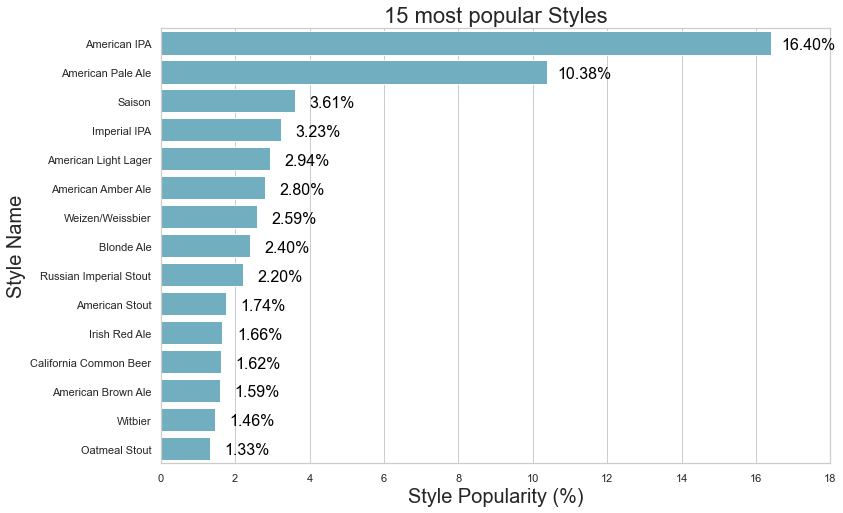

In [3]:
# Visual plot of style popularity in dataset
# from https://www.kaggle.com/code/samch08/home-brewed-beer
sns.set(style="whitegrid")
gb_style = recipes.groupby(['Style']).count().sort_values(['Name'], ascending=False).reset_index()[:15]
gb_style['Name'] = (gb_style['Name'] / len(recipes)) * 100
plt.figure(figsize=(12,8))
g = sns.barplot(x=gb_style['Name'], y=gb_style['Style'], orient='h',color ='c')
plt.title('15 most popular Styles', fontsize=22)
plt.ylabel('Style Name', fontsize=20)
plt.xlabel('Style Popularity (%)', fontsize=20)

plt.xlim(0,18)

for index, row in gb_style.iterrows():
    g.text(y=index+0.2,x=row['Name']+1,s='{:.2f}%'.format(row['Name']),
           color='black', ha="center", fontsize=16)

plt.show()

In [4]:
# Fuzzy Set Setup

# Antecedent/Consequent objects
og = ctrl.Antecedent(np.arange(1.000, 1.200, 0.001), 'OG')
fg = ctrl.Antecedent(np.arange(1.000, 1.050, 0.001), 'FG')
abv = ctrl.Antecedent(np.arange(3.00, 20.00, 0.01), 'ABV')
ibu = ctrl.Antecedent(np.arange(0.00, 800.00, 1.00), 'IBU')
srm = ctrl.Antecedent(np.arange(0.00, 55.00, 0.10), 'Color')
confidence = ctrl.Consequent(np.arange(0, 101, 1), 'Confidence')

In [5]:
# Membership functions
og['very low'] = fuzz.trapmf(og.universe, [1.000, 1.000, 1.025, 1.035])
og['low'] = fuzz.trimf(og.universe, [1.028, 1.038, 1.048])
og['medium'] = fuzz.trimf(og.universe, [1.035, 1.050, 1.065])
og['high'] = fuzz.trimf(og.universe, [1.055, 1.070, 1.085])
og['very high'] = fuzz.trapmf(og.universe, [1.075, 1.090, 1.200, 1.200])

fg['low'] = fuzz.trapmf(fg.universe, [1.000, 1.000, 1.005, 1.015])
fg['medium'] = fuzz.trimf(fg.universe, [1.010, 1.020, 1.030])
fg['high'] = fuzz.trimf(fg.universe, [1.020, 1.030, 1.040])
fg['very high'] = fuzz.trapmf(fg.universe, [1.030, 1.040, 1.050, 1.050])

abv['session'] = fuzz.trapmf(abv.universe, [3.00, 3.00, 3.50, 4.50])
abv['standard'] = fuzz.trimf(abv.universe, [3.50, 5.00, 6.50])
abv['elevated'] = fuzz.trimf(abv.universe, [5.50, 6.50, 7.50])
abv['high'] = fuzz.trimf(abv.universe, [6.50, 8.00, 10.00])
abv['very high'] = fuzz.trapmf(abv.universe, [8.00, 9.50, 20.00, 20.00])

ibu['low'] = fuzz.trapmf(ibu.universe, [0.00, 0.00, 5.00, 15.00])
ibu['moderate'] = fuzz.trimf(ibu.universe, [10.00, 17.50, 25.00])
ibu['pronounced'] = fuzz.trimf(ibu.universe, [17.50, 30.00, 42.50])
ibu['assertive'] = fuzz.trimf(ibu.universe, [35.00, 55.00, 75.00])
ibu['highly assertive'] = fuzz.trapmf(ibu.universe, [60.00, 80.00, 800.00, 800.00])

srm['straw'] = fuzz.trapmf(srm.universe, [0.00, 0.00, 2.50, 3.50])
srm['yellow'] = fuzz.trimf(srm.universe, [2.00, 3.50, 5.00])
srm['gold'] = fuzz.trimf(srm.universe, [4.00, 5.50, 7.00])
srm['amber'] = fuzz.trimf(srm.universe, [5.00, 7.50, 10.00])
srm['deep amber/light copper'] = fuzz.trimf(srm.universe, [9.00, 12.00, 15.00])
srm['copper'] = fuzz.trimf(srm.universe, [13.00, 15.50, 18.00])
srm['deep copper/light brown'] = fuzz.trimf(srm.universe, [16.00, 17.50, 19.00])
srm['brown'] = fuzz.trimf(srm.universe, [18.00, 20.50, 23.00])
srm['dark brown'] = fuzz.trimf(srm.universe, [21.00, 26.00, 31.00])
srm['very dark brown'] = fuzz.trimf(srm.universe, [29.00, 32.50, 36.00])
srm['black'] = fuzz.trimf(srm.universe, [29.00, 36.50, 44.00])
srm['black, opaque'] = fuzz.trapmf(srm.universe, [39.00, 45.00, 55.00, 55.00])

confidence['very low'] = fuzz.trapmf(confidence.universe, [0, 0, 15, 25])
confidence['low'] = fuzz.trimf(confidence.universe, [20, 35, 50])
confidence['medium'] = fuzz.trimf(confidence.universe, [40, 55, 70])
confidence['high'] = fuzz.trimf(confidence.universe, [60, 75, 90])
confidence['very high'] = fuzz.trapmf(confidence.universe, [80, 90, 100, 100])

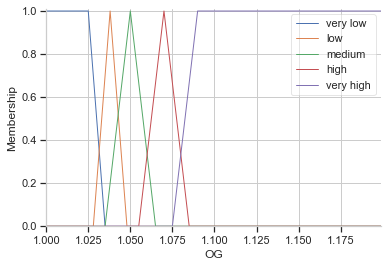

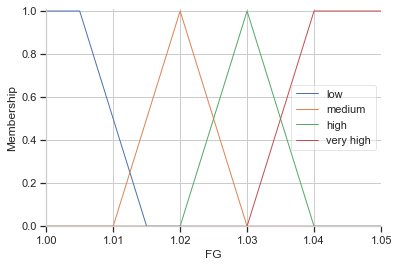

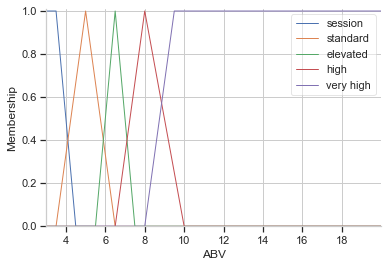

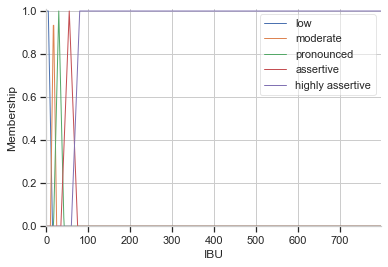

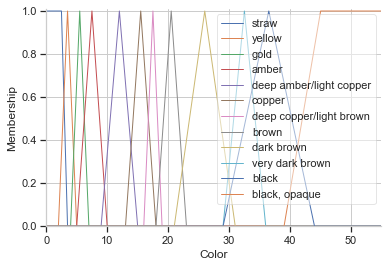

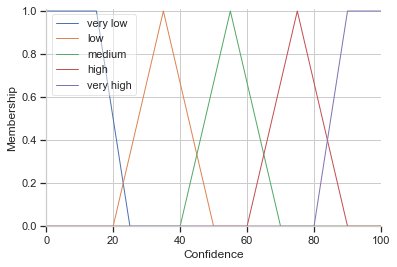

In [6]:
# Membership function views
og.view()
fg.view()
abv.view()
ibu.view()
srm.view()
confidence.view()

In [7]:
# Rule and system creation by style

# American IPA
# Fuzzy Rules
amIPA_og1 = ctrl.Rule(og['very low'],
                      confidence['very low'])
amIPA_og2 = ctrl.Rule(og['low'],
                      confidence['low'])
amIPA_og3 = ctrl.Rule(og['medium'],
                      confidence['high'])
amIPA_og4 = ctrl.Rule(og['high'],
                      confidence['high'])
amIPA_og5 = ctrl.Rule(og['very high'],
                      confidence['low'])

amIPA_fg1 = ctrl.Rule(fg['low'],
                      confidence['very high'])
amIPA_fg2 = ctrl.Rule(fg['medium'],
                      confidence['medium'])
amIPA_fg3 = ctrl.Rule(fg['high'],
                      confidence['low'])
amIPA_fg4 = ctrl.Rule(fg['very high'],
                      confidence['very low'])

amIPA_abv1 = ctrl.Rule(abv['session'],
                       confidence['very low'])
amIPA_abv2 = ctrl.Rule(abv['standard'],
                       confidence['medium'])
amIPA_abv3 = ctrl.Rule(abv['elevated'],
                       confidence['very high'])
amIPA_abv4 = ctrl.Rule(abv['high'],
                       confidence['medium'])
amIPA_abv5 = ctrl.Rule(abv['very high'],
                       confidence['low'])

amIPA_ibu1 = ctrl.Rule(ibu['low'],
                       confidence['very low'])
amIPA_ibu2 = ctrl.Rule(ibu['moderate'],
                       confidence['very low'])
amIPA_ibu3 = ctrl.Rule(ibu['pronounced'],
                       confidence['medium'])
amIPA_ibu4 = ctrl.Rule(ibu['assertive'],
                       confidence['very high'])
amIPA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                       confidence['high'])

amIPA_srm1 = ctrl.Rule(srm['straw'],
                       confidence['very low'])
amIPA_srm2 = ctrl.Rule(srm['yellow'],
                       confidence['low'])
amIPA_srm3 = ctrl.Rule(srm['gold'],
                       confidence['medium'])
amIPA_srm4 = ctrl.Rule(srm['amber'],
                       confidence['very high'])
amIPA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                       confidence['very high'])
amIPA_srm6 = ctrl.Rule(srm['copper'],
                       confidence['medium'])
amIPA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                       confidence['low'])
amIPA_srm8 = ctrl.Rule(srm['brown'],
                       confidence['very low'])
amIPA_srm9 = ctrl.Rule(srm['dark brown'],
                       confidence['very low'])
amIPA_srm10 = ctrl.Rule(srm['very dark brown'],
                        confidence['very low'])
amIPA_srm11 = ctrl.Rule(srm['black'],
                        confidence['very low'])
amIPA_srm12 = ctrl.Rule(srm['black, opaque'],
                        confidence['very low'])

# Control system creation
amIPA_ctrl = ctrl.ControlSystem([amIPA_og1, amIPA_og2, amIPA_og3, amIPA_og4, amIPA_og5,
                                 amIPA_fg1, amIPA_fg2, amIPA_fg3, amIPA_fg4,
                                 amIPA_abv1, amIPA_abv2, amIPA_abv3, amIPA_abv4, amIPA_abv5,
                                 amIPA_ibu1, amIPA_ibu2, amIPA_ibu3, amIPA_ibu4, amIPA_ibu5,
                                 amIPA_srm1, amIPA_srm2, amIPA_srm3, amIPA_srm4, amIPA_srm5, amIPA_srm6,
                                 amIPA_srm7, amIPA_srm8, amIPA_srm9, amIPA_srm10, amIPA_srm11, amIPA_srm12
                                ])


# Simulation
amIPA = ctrl.ControlSystemSimulation(amIPA_ctrl)

In [8]:
# American Pale Ale
# Fuzzy Rules
amPA_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
amPA_og2 = ctrl.Rule(og['low'],
                     confidence['medium'])
amPA_og3 = ctrl.Rule(og['medium'],
                     confidence['very high'])
amPA_og4 = ctrl.Rule(og['high'],
                     confidence['medium'])
amPA_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

amPA_fg1 = ctrl.Rule(fg['low'],
                     confidence['very high'])
amPA_fg2 = ctrl.Rule(fg['medium'],
                     confidence['high'])
amPA_fg3 = ctrl.Rule(fg['high'],
                     confidence['low'])
amPA_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

amPA_abv1 = ctrl.Rule(abv['session'],
                      confidence['low'])
amPA_abv2 = ctrl.Rule(abv['standard'],
                      confidence['very high'])
amPA_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
amPA_abv4 = ctrl.Rule(abv['high'],
                      confidence['low'])
amPA_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

amPA_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
amPA_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['low'])
amPA_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['high'])
amPA_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['high'])
amPA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['low'])

amPA_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
amPA_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['low'])
amPA_srm3 = ctrl.Rule(srm['gold'],
                      confidence['high'])
amPA_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very high'])
amPA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['medium'])
amPA_srm6 = ctrl.Rule(srm['copper'],
                      confidence['low'])
amPA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
amPA_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
amPA_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
amPA_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
amPA_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
amPA_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
amPA_ctrl = ctrl.ControlSystem([amPA_og1, amPA_og2, amPA_og3, amPA_og4, amPA_og5,
                                amPA_fg1, amPA_fg2, amPA_fg3, amPA_fg4,
                                amPA_abv1, amPA_abv2, amPA_abv3, amPA_abv4, amPA_abv5,
                                amPA_ibu1, amPA_ibu2, amPA_ibu3, amPA_ibu4, amPA_ibu5,
                                amPA_srm1, amPA_srm2, amPA_srm3, amPA_srm4, amPA_srm5, amPA_srm6,
                                amPA_srm7, amPA_srm8, amPA_srm9, amPA_srm10, amPA_srm11, amPA_srm12
                                ])

# Simulation
amPA = ctrl.ControlSystemSimulation(amPA_ctrl)

In [9]:
# Saison
# Fuzzy Rules
saison_og1 = ctrl.Rule(og['very low'],
                       confidence['very low'])
saison_og2 = ctrl.Rule(og['low'],
                       confidence['low'])
saison_og3 = ctrl.Rule(og['medium'],
                       confidence['high'])
saison_og4 = ctrl.Rule(og['high'],
                       confidence['high'])
saison_og5 = ctrl.Rule(og['very high'],
                       confidence['low'])

saison_fg1 = ctrl.Rule(fg['low'],
                       confidence['high'])
saison_fg2 = ctrl.Rule(fg['medium'],
                       confidence['low'])
saison_fg3 = ctrl.Rule(fg['high'],
                       confidence['very low'])
saison_fg4 = ctrl.Rule(fg['very high'],
                       confidence['very low'])

saison_abv1 = ctrl.Rule(abv['session'],
                        confidence['low'])
saison_abv2 = ctrl.Rule(abv['standard'],
                        confidence['medium'])
saison_abv3 = ctrl.Rule(abv['elevated'],
                        confidence['very high'])
saison_abv4 = ctrl.Rule(abv['high'],
                        confidence['medium'])
saison_abv5 = ctrl.Rule(abv['very high'],
                        confidence['low'])

saison_ibu1 = ctrl.Rule(ibu['low'],
                        confidence['very low'])
saison_ibu2 = ctrl.Rule(ibu['moderate'],
                        confidence['medium'])
saison_ibu3 = ctrl.Rule(ibu['pronounced'],
                        confidence['high'])
saison_ibu4 = ctrl.Rule(ibu['assertive'],
                        confidence['low'])
saison_ibu5 = ctrl.Rule(ibu['highly assertive'],
                        confidence['very low'])

saison_srm1 = ctrl.Rule(srm['straw'],
                        confidence['very low'])
saison_srm2 = ctrl.Rule(srm['yellow'],
                        confidence['low'])
saison_srm3 = ctrl.Rule(srm['gold'],
                        confidence['high'])
saison_srm4 = ctrl.Rule(srm['amber'],
                        confidence['very high'])
saison_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                        confidence['high'])
saison_srm6 = ctrl.Rule(srm['copper'],
                        confidence['high'])
saison_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                        confidence['medium'])
saison_srm8 = ctrl.Rule(srm['brown'],
                        confidence['medium'])
saison_srm9 = ctrl.Rule(srm['dark brown'],
                        confidence['low'])
saison_srm10 = ctrl.Rule(srm['very dark brown'],
                         confidence['very low'])
saison_srm11 = ctrl.Rule(srm['black'],
                         confidence['very low'])
saison_srm12 = ctrl.Rule(srm['black, opaque'],
                         confidence['very low'])

# Control system creation
saison_ctrl = ctrl.ControlSystem([saison_og1, saison_og2, saison_og3, saison_og4, saison_og5,
                                  saison_fg1, saison_fg2, saison_fg3, saison_fg4,
                                  saison_abv1, saison_abv2, saison_abv3, saison_abv4, saison_abv5,
                                  saison_ibu1, saison_ibu2, saison_ibu3, saison_ibu4, saison_ibu5,
                                  saison_srm1, saison_srm2, saison_srm3, saison_srm4, saison_srm5, saison_srm6,
                                  saison_srm7, saison_srm8, saison_srm9, saison_srm10, saison_srm11, saison_srm12
                                ])

# Simulation
saison = ctrl.ControlSystemSimulation(saison_ctrl)

In [10]:
# Imperial IPA
# Fuzzy Rules
imIPA_og1 = ctrl.Rule(og['very low'],
                      confidence['very low'])
imIPA_og2 = ctrl.Rule(og['low'],
                      confidence['very low'])
imIPA_og3 = ctrl.Rule(og['medium'],
                      confidence['low'])
imIPA_og4 = ctrl.Rule(og['high'],
                      confidence['very high'])
imIPA_og5 = ctrl.Rule(og['very high'],
                      confidence['high'])

imIPA_fg1 = ctrl.Rule(fg['low'],
                      confidence['medium'])
imIPA_fg2 = ctrl.Rule(fg['medium'],
                      confidence['high'])
imIPA_fg3 = ctrl.Rule(fg['high'],
                      confidence['low'])
imIPA_fg4 = ctrl.Rule(fg['very high'],
                      confidence['very low'])

imIPA_abv1 = ctrl.Rule(abv['session'],
                       confidence['very low'])
imIPA_abv2 = ctrl.Rule(abv['standard'],
                       confidence['very low'])
imIPA_abv3 = ctrl.Rule(abv['elevated'],
                       confidence['low'])
imIPA_abv4 = ctrl.Rule(abv['high'],
                       confidence['high'])
imIPA_abv5 = ctrl.Rule(abv['very high'],
                       confidence['very high'])

imIPA_ibu1 = ctrl.Rule(ibu['low'],
                       confidence['very low'])
imIPA_ibu2 = ctrl.Rule(ibu['moderate'],
                       confidence['very low'])
imIPA_ibu3 = ctrl.Rule(ibu['pronounced'],
                       confidence['very low'])
imIPA_ibu4 = ctrl.Rule(ibu['assertive'],
                       confidence['medium'])
imIPA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                       confidence['very high'])

imIPA_srm1 = ctrl.Rule(srm['straw'],
                       confidence['very low'])
imIPA_srm2 = ctrl.Rule(srm['yellow'],
                       confidence['low'])
imIPA_srm3 = ctrl.Rule(srm['gold'],
                       confidence['medium'])
imIPA_srm4 = ctrl.Rule(srm['amber'],
                       confidence['high'])
imIPA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                       confidence['high'])
imIPA_srm6 = ctrl.Rule(srm['copper'],
                       confidence['medium'])
imIPA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                       confidence['low'])
imIPA_srm8 = ctrl.Rule(srm['brown'],
                       confidence['very low'])
imIPA_srm9 = ctrl.Rule(srm['dark brown'],
                       confidence['very low'])
imIPA_srm10 = ctrl.Rule(srm['very dark brown'],
                        confidence['very low'])
imIPA_srm11 = ctrl.Rule(srm['black'],
                        confidence['very low'])
imIPA_srm12 = ctrl.Rule(srm['black, opaque'],
                        confidence['very low'])

# Control system creation
imIPA_ctrl = ctrl.ControlSystem([imIPA_og1, imIPA_og2, imIPA_og3, imIPA_og4, imIPA_og5,
                                 imIPA_fg1, imIPA_fg2, imIPA_fg3, imIPA_fg4,
                                 imIPA_abv1, imIPA_abv2, imIPA_abv3, imIPA_abv4, imIPA_abv5,
                                 imIPA_ibu1, imIPA_ibu2, imIPA_ibu3, imIPA_ibu4, imIPA_ibu5,
                                 imIPA_srm1, imIPA_srm2, imIPA_srm3, imIPA_srm4, imIPA_srm5, imIPA_srm6,
                                 imIPA_srm7, imIPA_srm8, imIPA_srm9, imIPA_srm10, imIPA_srm11, imIPA_srm12
                                ])

# Simulation
imIPA = ctrl.ControlSystemSimulation(imIPA_ctrl)

In [11]:
# American Light Lager
# Fuzzy Rules
amLL_og1 = ctrl.Rule(og['very low'],
                     confidence['very high'])
amLL_og2 = ctrl.Rule(og['low'],
                     confidence['high'])
amLL_og3 = ctrl.Rule(og['medium'],
                     confidence['medium'])
amLL_og4 = ctrl.Rule(og['high'],
                     confidence['very low'])
amLL_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

amLL_fg1 = ctrl.Rule(fg['low'],
                     confidence['very high'])
amLL_fg2 = ctrl.Rule(fg['medium'],
                     confidence['medium'])
amLL_fg3 = ctrl.Rule(fg['high'],
                     confidence['very low'])
amLL_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

amLL_abv1 = ctrl.Rule(abv['session'],
                      confidence['very high'])
amLL_abv2 = ctrl.Rule(abv['standard'],
                      confidence['medium'])
amLL_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['very low'])
amLL_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
amLL_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

amLL_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very high'])
amLL_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['medium'])
amLL_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['very low'])
amLL_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['very low'])
amLL_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

amLL_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very high'])
amLL_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['high'])
amLL_srm3 = ctrl.Rule(srm['gold'],
                      confidence['medium'])
amLL_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very low'])
amLL_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
amLL_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very low'])
amLL_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
amLL_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
amLL_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
amLL_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
amLL_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
amLL_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
amLL_ctrl = ctrl.ControlSystem([amLL_og1, amLL_og2, amLL_og3, amLL_og4, amLL_og5,
                                amLL_fg1, amLL_fg2, amLL_fg3, amLL_fg4,
                                amLL_abv1, amLL_abv2, amLL_abv3, amLL_abv4, amLL_abv5,
                                amLL_ibu1, amLL_ibu2, amLL_ibu3, amLL_ibu4, amLL_ibu5,
                                amLL_srm1, amLL_srm2, amLL_srm3, amLL_srm4, amLL_srm5, amLL_srm6,
                                amLL_srm7, amLL_srm8, amLL_srm9, amLL_srm10, amLL_srm11, amLL_srm12
                                ])

# Simulation
amLL = ctrl.ControlSystemSimulation(amLL_ctrl)

In [12]:
# American Amber Ale
# Fuzzy Rules
amAA_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
amAA_og2 = ctrl.Rule(og['low'],
                     confidence['medium'])
amAA_og3 = ctrl.Rule(og['medium'],
                     confidence['very high'])
amAA_og4 = ctrl.Rule(og['high'],
                     confidence['medium'])
amAA_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

amAA_fg1 = ctrl.Rule(fg['low'],
                     confidence['very high'])
amAA_fg2 = ctrl.Rule(fg['medium'],
                     confidence['medium'])
amAA_fg3 = ctrl.Rule(fg['high'],
                     confidence['very low'])
amAA_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

amAA_abv1 = ctrl.Rule(abv['session'],
                      confidence['low'])
amAA_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
amAA_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
amAA_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
amAA_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

amAA_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
amAA_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['low'])
amAA_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['very high'])
amAA_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['medium'])
amAA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

amAA_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
amAA_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
amAA_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
amAA_srm4 = ctrl.Rule(srm['amber'],
                      confidence['low'])
amAA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very high'])
amAA_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very high'])
amAA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['medium'])
amAA_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
amAA_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
amAA_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
amAA_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
amAA_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
amAA_ctrl = ctrl.ControlSystem([amAA_og1, amAA_og2, amAA_og3, amAA_og4, amAA_og5,
                                amAA_fg1, amAA_fg2, amAA_fg3, amAA_fg4,
                                amAA_abv1, amAA_abv2, amAA_abv3, amAA_abv4, amAA_abv5,
                                amAA_ibu1, amAA_ibu2, amAA_ibu3, amAA_ibu4, amAA_ibu5,
                                amAA_srm1, amAA_srm2, amAA_srm3, amAA_srm4, amAA_srm5, amAA_srm6,
                                amAA_srm7, amAA_srm8, amAA_srm9, amAA_srm10, amAA_srm11, amAA_srm12
                                ])

# Simulation
amAA = ctrl.ControlSystemSimulation(amAA_ctrl)

In [13]:
# Weizen/Weissbier
# Fuzzy Rules
weiss_og1 = ctrl.Rule(og['very low'],
                      confidence['low'])
weiss_og2 = ctrl.Rule(og['low'],
                      confidence['medium'])
weiss_og3 = ctrl.Rule(og['medium'],
                      confidence['high'])
weiss_og4 = ctrl.Rule(og['high'],
                      confidence['low'])
weiss_og5 = ctrl.Rule(og['very high'],
                      confidence['very low'])

weiss_fg1 = ctrl.Rule(fg['low'],
                      confidence['very high'])
weiss_fg2 = ctrl.Rule(fg['medium'],
                      confidence['medium'])
weiss_fg3 = ctrl.Rule(fg['high'],
                      confidence['low'])
weiss_fg4 = ctrl.Rule(fg['very high'],
                      confidence['very low'])

weiss_abv1 = ctrl.Rule(abv['session'],
                       confidence['medium'])
weiss_abv2 = ctrl.Rule(abv['standard'],
                       confidence['high'])
weiss_abv3 = ctrl.Rule(abv['elevated'],
                       confidence['medium'])
weiss_abv4 = ctrl.Rule(abv['high'],
                       confidence['very low'])
weiss_abv5 = ctrl.Rule(abv['very high'],
                       confidence['very low'])

weiss_ibu1 = ctrl.Rule(ibu['low'],
                       confidence['very high'])
weiss_ibu2 = ctrl.Rule(ibu['moderate'],
                       confidence['medium'])
weiss_ibu3 = ctrl.Rule(ibu['pronounced'],
                       confidence['low'])
weiss_ibu4 = ctrl.Rule(ibu['assertive'],
                       confidence['very low'])
weiss_ibu5 = ctrl.Rule(ibu['highly assertive'],
                       confidence['very low'])

weiss_srm1 = ctrl.Rule(srm['straw'],
                       confidence['high'])
weiss_srm2 = ctrl.Rule(srm['yellow'],
                       confidence['very high'])
weiss_srm3 = ctrl.Rule(srm['gold'],
                       confidence['high'])
weiss_srm4 = ctrl.Rule(srm['amber'],
                       confidence['medium'])
weiss_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                       confidence['low'])
weiss_srm6 = ctrl.Rule(srm['copper'],
                       confidence['very low'])
weiss_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                       confidence['very low'])
weiss_srm8 = ctrl.Rule(srm['brown'],
                       confidence['very low'])
weiss_srm9 = ctrl.Rule(srm['dark brown'],
                       confidence['very low'])
weiss_srm10 = ctrl.Rule(srm['very dark brown'],
                        confidence['very low'])
weiss_srm11 = ctrl.Rule(srm['black'],
                        confidence['very low'])
weiss_srm12 = ctrl.Rule(srm['black, opaque'],
                        confidence['very low'])

# Control system creation
weiss_ctrl = ctrl.ControlSystem([weiss_og1, weiss_og2, weiss_og3, weiss_og4, weiss_og5,
                                 weiss_fg1, weiss_fg2, weiss_fg3, weiss_fg4,
                                 weiss_abv1, weiss_abv2, weiss_abv3, weiss_abv4, weiss_abv5,
                                 weiss_ibu1, weiss_ibu2, weiss_ibu3, weiss_ibu4, weiss_ibu5,
                                 weiss_srm1, weiss_srm2, weiss_srm3, weiss_srm4, weiss_srm5, weiss_srm6,
                                 weiss_srm7, weiss_srm8, weiss_srm9, weiss_srm10, weiss_srm11, weiss_srm12
                                ])

# Simulation
weiss = ctrl.ControlSystemSimulation(weiss_ctrl)

In [14]:
# Blonde Ale
# Fuzzy Rules
blAl_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
blAl_og2 = ctrl.Rule(og['low'],
                     confidence['high'])
blAl_og3 = ctrl.Rule(og['medium'],
                     confidence['high'])
blAl_og4 = ctrl.Rule(og['high'],
                     confidence['low'])
blAl_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

blAl_fg1 = ctrl.Rule(fg['low'],
                     confidence['very high'])
blAl_fg2 = ctrl.Rule(fg['medium'],
                     confidence['medium'])
blAl_fg3 = ctrl.Rule(fg['high'],
                     confidence['very low'])
blAl_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

blAl_abv1 = ctrl.Rule(abv['session'],
                      confidence['high'])
blAl_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
blAl_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
blAl_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
blAl_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

blAl_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['low'])
blAl_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['high'])
blAl_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['high'])
blAl_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['very low'])
blAl_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

blAl_srm1 = ctrl.Rule(srm['straw'],
                      confidence['medium'])
blAl_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['high'])
blAl_srm3 = ctrl.Rule(srm['gold'],
                      confidence['high'])
blAl_srm4 = ctrl.Rule(srm['amber'],
                      confidence['medium'])
blAl_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
blAl_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very low'])
blAl_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
blAl_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
blAl_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
blAl_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
blAl_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
blAl_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
blAl_ctrl = ctrl.ControlSystem([blAl_og1, blAl_og2, blAl_og3, blAl_og4, blAl_og5,
                                blAl_fg1, blAl_fg2, blAl_fg3, blAl_fg4,
                                blAl_abv1, blAl_abv2, blAl_abv3, blAl_abv4, blAl_abv5,
                                blAl_ibu1, blAl_ibu2, blAl_ibu3, blAl_ibu4, blAl_ibu5,
                                blAl_srm1, blAl_srm2, blAl_srm3, blAl_srm4, blAl_srm5, blAl_srm6,
                                blAl_srm7, blAl_srm8, blAl_srm9, blAl_srm10, blAl_srm11, blAl_srm12
                                ])

# Simulation
blAl = ctrl.ControlSystemSimulation(blAl_ctrl)

In [15]:
# Russian Imperial Stout
# Fuzzy Rules
imST_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
imST_og2 = ctrl.Rule(og['low'],
                     confidence['very low'])
imST_og3 = ctrl.Rule(og['medium'],
                     confidence['very low'])
imST_og4 = ctrl.Rule(og['high'],
                     confidence['medium'])
imST_og5 = ctrl.Rule(og['very high'],
                     confidence['very high'])

imST_fg1 = ctrl.Rule(fg['low'],
                     confidence['very low'])
imST_fg2 = ctrl.Rule(fg['medium'],
                     confidence['very high'])
imST_fg3 = ctrl.Rule(fg['high'],
                     confidence['high'])
imST_fg4 = ctrl.Rule(fg['very high'],
                     confidence['low'])

imST_abv1 = ctrl.Rule(abv['session'],
                      confidence['very low'])
imST_abv2 = ctrl.Rule(abv['standard'],
                      confidence['very low'])
imST_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['very low'])
imST_abv4 = ctrl.Rule(abv['high'],
                      confidence['high'])
imST_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very high'])

imST_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
imST_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['very low'])
imST_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['very low'])
imST_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['high'])
imST_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very high'])

imST_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
imST_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
imST_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
imST_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very low'])
imST_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
imST_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very low'])
imST_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
imST_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
imST_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['low'])
imST_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['high'])
imST_srm11 = ctrl.Rule(srm['black'],
                       confidence['very high'])
imST_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['medium'])

# Control system creation
imST_ctrl = ctrl.ControlSystem([imST_og1, imST_og2, imST_og3, imST_og4, imST_og5,
                                imST_fg1, imST_fg2, imST_fg3, imST_fg4,
                                imST_abv1, imST_abv2, imST_abv3, imST_abv4, imST_abv5,
                                imST_ibu1, imST_ibu2, imST_ibu3, imST_ibu4, imST_ibu5,
                                imST_srm1, imST_srm2, imST_srm3, imST_srm4, imST_srm5, imST_srm6,
                                imST_srm7, imST_srm8, imST_srm9, imST_srm10, imST_srm11, imST_srm12
                                ])

# Simulation
imST = ctrl.ControlSystemSimulation(imST_ctrl)

In [16]:
# American Stout
# Fuzzy Rules
amST_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
amST_og2 = ctrl.Rule(og['low'],
                     confidence['very low'])
amST_og3 = ctrl.Rule(og['medium'],
                     confidence['medium'])
amST_og4 = ctrl.Rule(og['high'],
                     confidence['very high'])
amST_og5 = ctrl.Rule(og['very high'],
                     confidence['low'])

amST_fg1 = ctrl.Rule(fg['low'],
                     confidence['medium'])
amST_fg2 = ctrl.Rule(fg['medium'],
                     confidence['high'])
amST_fg3 = ctrl.Rule(fg['high'],
                     confidence['medium'])
amST_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

amST_abv1 = ctrl.Rule(abv['session'],
                      confidence['very low'])
amST_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
amST_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['very high'])
amST_abv4 = ctrl.Rule(abv['high'],
                      confidence['medium'])
amST_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

amST_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
amST_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['very low'])
amST_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['medium'])
amST_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['very high'])
amST_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['medium'])

amST_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
amST_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
amST_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
amST_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very low'])
amST_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
amST_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very low'])
amST_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
amST_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
amST_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['medium'])
amST_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very high'])
amST_srm11 = ctrl.Rule(srm['black'],
                       confidence['high'])
amST_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['medium'])

# Control system creation
amST_ctrl = ctrl.ControlSystem([amST_og1, amST_og2, amST_og3, amST_og4, amST_og5,
                                amST_fg1, amST_fg2, amST_fg3, amST_fg4,
                                amST_abv1, amST_abv2, amST_abv3, amST_abv4, amST_abv5,
                                amST_ibu1, amST_ibu2, amST_ibu3, amST_ibu4, amST_ibu5,
                                amST_srm1, amST_srm2, amST_srm3, amST_srm4, amST_srm5, amST_srm6,
                                amST_srm7, amST_srm8, amST_srm9, amST_srm10, amST_srm11, amST_srm12
                                ])

# Simulation
amST = ctrl.ControlSystemSimulation(amST_ctrl)

In [17]:
# Irish Red Ale
# Fuzzy Rules
irRA_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
irRA_og2 = ctrl.Rule(og['low'],
                     confidence['very high'])
irRA_og3 = ctrl.Rule(og['medium'],
                     confidence['high'])
irRA_og4 = ctrl.Rule(og['high'],
                     confidence['very low'])
irRA_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

irRA_fg1 = ctrl.Rule(fg['low'],
                     confidence['very high'])
irRA_fg2 = ctrl.Rule(fg['medium'],
                     confidence['medium'])
irRA_fg3 = ctrl.Rule(fg['high'],
                     confidence['very low'])
irRA_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

irRA_abv1 = ctrl.Rule(abv['session'],
                      confidence['very high'])
irRA_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
irRA_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
irRA_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
irRA_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

irRA_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
irRA_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['high'])
irRA_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['high'])
irRA_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['very low'])
irRA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

irRA_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
irRA_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
irRA_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
irRA_srm4 = ctrl.Rule(srm['amber'],
                      confidence['low'])
irRA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very high'])
irRA_srm6 = ctrl.Rule(srm['copper'],
                      confidence['high'])
irRA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
irRA_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
irRA_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
irRA_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
irRA_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
irRA_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
irRA_ctrl = ctrl.ControlSystem([irRA_og1, irRA_og2, irRA_og3, irRA_og4, irRA_og5,
                                irRA_fg1, irRA_fg2, irRA_fg3, irRA_fg4,
                                irRA_abv1, irRA_abv2, irRA_abv3, irRA_abv4, irRA_abv5,
                                irRA_ibu1, irRA_ibu2, irRA_ibu3, irRA_ibu4, irRA_ibu5,
                                irRA_srm1, irRA_srm2, irRA_srm3, irRA_srm4, irRA_srm5, irRA_srm6,
                                irRA_srm7, irRA_srm8, irRA_srm9, irRA_srm10, irRA_srm11, irRA_srm12
                                ])

# Simulation
irRA = ctrl.ControlSystemSimulation(irRA_ctrl)

In [18]:
# California Common Beer
# Fuzzy Rules
calC_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
calC_og2 = ctrl.Rule(og['low'],
                     confidence['low'])
calC_og3 = ctrl.Rule(og['medium'],
                     confidence['very high'])
calC_og4 = ctrl.Rule(og['high'],
                     confidence['medium'])
calC_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

calC_fg1 = ctrl.Rule(fg['low'],
                     confidence['high'])
calC_fg2 = ctrl.Rule(fg['medium'],
                     confidence['high'])
calC_fg3 = ctrl.Rule(fg['high'],
                     confidence['low'])
calC_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

calC_abv1 = ctrl.Rule(abv['session'],
                      confidence['low'])
calC_abv2 = ctrl.Rule(abv['standard'],
                      confidence['very high'])
calC_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
calC_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
calC_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

calC_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
calC_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['very low'])
calC_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['high'])
calC_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['medium'])
calC_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

calC_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
calC_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
calC_srm3 = ctrl.Rule(srm['gold'],
                      confidence['low'])
calC_srm4 = ctrl.Rule(srm['amber'],
                      confidence['high'])
calC_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very high'])
calC_srm6 = ctrl.Rule(srm['copper'],
                      confidence['medium'])
calC_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
calC_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very low'])
calC_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very low'])
calC_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very low'])
calC_srm11 = ctrl.Rule(srm['black'],
                       confidence['very low'])
calC_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
calC_ctrl = ctrl.ControlSystem([calC_og1, calC_og2, calC_og3, calC_og4, calC_og5,
                                calC_fg1, calC_fg2, calC_fg3, calC_fg4,
                                calC_abv1, calC_abv2, calC_abv3, calC_abv4, calC_abv5,
                                calC_ibu1, calC_ibu2, calC_ibu3, calC_ibu4, calC_ibu5,
                                calC_srm1, calC_srm2, calC_srm3, calC_srm4, calC_srm5, calC_srm6,
                                calC_srm7, calC_srm8, calC_srm9, calC_srm10, calC_srm11, calC_srm12
                                ])

# Simulation
calC = ctrl.ControlSystemSimulation(calC_ctrl)

In [19]:
# American Brown Ale
# Fuzzy Rules
amBA_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
amBA_og2 = ctrl.Rule(og['low'],
                     confidence['low'])
amBA_og3 = ctrl.Rule(og['medium'],
                     confidence['very high'])
amBA_og4 = ctrl.Rule(og['high'],
                     confidence['medium'])
amBA_og5 = ctrl.Rule(og['very high'],
                     confidence['very low'])

amBA_fg1 = ctrl.Rule(fg['low'],
                     confidence['high'])
amBA_fg2 = ctrl.Rule(fg['medium'],
                     confidence['medium'])
amBA_fg3 = ctrl.Rule(fg['high'],
                     confidence['very low'])
amBA_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

amBA_abv1 = ctrl.Rule(abv['session'],
                      confidence['low'])
amBA_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
amBA_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['medium'])
amBA_abv4 = ctrl.Rule(abv['high'],
                      confidence['very low'])
amBA_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

amBA_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
amBA_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['medium'])
amBA_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['high'])
amBA_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['very low'])
amBA_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

amBA_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
amBA_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
amBA_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
amBA_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very low'])
amBA_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
amBA_srm6 = ctrl.Rule(srm['copper'],
                      confidence['low'])
amBA_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['low'])
amBA_srm8 = ctrl.Rule(srm['brown'],
                      confidence['very high'])
amBA_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['very high'])
amBA_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very high'])
amBA_srm11 = ctrl.Rule(srm['black'],
                       confidence['medium'])
amBA_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['very low'])

# Control system creation
amBA_ctrl = ctrl.ControlSystem([amBA_og1, amBA_og2, amBA_og3, amBA_og4, amBA_og5,
                                amBA_fg1, amBA_fg2, amBA_fg3, amBA_fg4,
                                amBA_abv1, amBA_abv2, amBA_abv3, amBA_abv4, amBA_abv5,
                                amBA_ibu1, amBA_ibu2, amBA_ibu3, amBA_ibu4, amBA_ibu5,
                                amBA_srm1, amBA_srm2, amBA_srm3, amBA_srm4, amBA_srm5, amBA_srm6,
                                amBA_srm7, amBA_srm8, amBA_srm9, amBA_srm10, amBA_srm11, amBA_srm12
                                ])

# Simulation
amBA = ctrl.ControlSystemSimulation(amBA_ctrl)

In [20]:
# Witbier
# Fuzzy Rules
witbr_og1 = ctrl.Rule(og['very low'],
                      confidence['low'])
witbr_og2 = ctrl.Rule(og['low'],
                      confidence['medium'])
witbr_og3 = ctrl.Rule(og['medium'],
                      confidence['high'])
witbr_og4 = ctrl.Rule(og['high'],
                      confidence['very low'])
witbr_og5 = ctrl.Rule(og['very high'],
                      confidence['very low'])

witbr_fg1 = ctrl.Rule(fg['low'],
                      confidence['high'])
witbr_fg2 = ctrl.Rule(fg['medium'],
                      confidence['medium'])
witbr_fg3 = ctrl.Rule(fg['high'],
                      confidence['low'])
witbr_fg4 = ctrl.Rule(fg['very high'],
                      confidence['very low'])

witbr_abv1 = ctrl.Rule(abv['session'],
                       confidence['very low'])
witbr_abv2 = ctrl.Rule(abv['standard'],
                       confidence['high'])
witbr_abv3 = ctrl.Rule(abv['elevated'],
                       confidence['low'])
witbr_abv4 = ctrl.Rule(abv['high'],
                       confidence['very low'])
witbr_abv5 = ctrl.Rule(abv['very high'],
                       confidence['very low'])

witbr_ibu1 = ctrl.Rule(ibu['low'],
                       confidence['very high'])
witbr_ibu2 = ctrl.Rule(ibu['moderate'],
                       confidence['high'])
witbr_ibu3 = ctrl.Rule(ibu['pronounced'],
                       confidence['medium'])
witbr_ibu4 = ctrl.Rule(ibu['assertive'],
                       confidence['very low'])
witbr_ibu5 = ctrl.Rule(ibu['highly assertive'],
                       confidence['very low'])

witbr_srm1 = ctrl.Rule(srm['straw'],
                       confidence['very high'])
witbr_srm2 = ctrl.Rule(srm['yellow'],
                       confidence['high'])
witbr_srm3 = ctrl.Rule(srm['gold'],
                       confidence['medium'])
witbr_srm4 = ctrl.Rule(srm['amber'],
                       confidence['low'])
witbr_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                       confidence['very low'])
witbr_srm6 = ctrl.Rule(srm['copper'],
                       confidence['very low'])
witbr_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                       confidence['very low'])
witbr_srm8 = ctrl.Rule(srm['brown'],
                       confidence['very low'])
witbr_srm9 = ctrl.Rule(srm['dark brown'],
                       confidence['very low'])
witbr_srm10 = ctrl.Rule(srm['very dark brown'],
                        confidence['very low'])
witbr_srm11 = ctrl.Rule(srm['black'],
                        confidence['very low'])
witbr_srm12 = ctrl.Rule(srm['black, opaque'],
                        confidence['very low'])

# Control system creation
witbr_ctrl = ctrl.ControlSystem([witbr_og1, witbr_og2, witbr_og3, witbr_og4, witbr_og5,
                                 witbr_fg1, witbr_fg2, witbr_fg3, witbr_fg4,
                                 witbr_abv1, witbr_abv2, witbr_abv3, witbr_abv4, witbr_abv5,
                                 witbr_ibu1, witbr_ibu2, witbr_ibu3, witbr_ibu4, witbr_ibu5,
                                 witbr_srm1, witbr_srm2, witbr_srm3, witbr_srm4, witbr_srm5, witbr_srm6,
                                 witbr_srm7, witbr_srm8, witbr_srm9, witbr_srm10, witbr_srm11, witbr_srm12
                                ])

# Simulation
witbr = ctrl.ControlSystemSimulation(witbr_ctrl)

In [21]:
# Oatmeal Stout
# Fuzzy Rules
omST_og1 = ctrl.Rule(og['very low'],
                     confidence['very low'])
omST_og2 = ctrl.Rule(og['low'],
                     confidence['low'])
omST_og3 = ctrl.Rule(og['medium'],
                     confidence['high'])
omST_og4 = ctrl.Rule(og['high'],
                     confidence['very high'])
omST_og5 = ctrl.Rule(og['very high'],
                     confidence['low'])

omST_fg1 = ctrl.Rule(fg['low'],
                     confidence['high'])
omST_fg2 = ctrl.Rule(fg['medium'],
                     confidence['very high'])
omST_fg3 = ctrl.Rule(fg['high'],
                     confidence['medium'])
omST_fg4 = ctrl.Rule(fg['very high'],
                     confidence['very low'])

omST_abv1 = ctrl.Rule(abv['session'],
                      confidence['low'])
omST_abv2 = ctrl.Rule(abv['standard'],
                      confidence['high'])
omST_abv3 = ctrl.Rule(abv['elevated'],
                      confidence['high'])
omST_abv4 = ctrl.Rule(abv['high'],
                      confidence['low'])
omST_abv5 = ctrl.Rule(abv['very high'],
                      confidence['very low'])

omST_ibu1 = ctrl.Rule(ibu['low'],
                      confidence['very low'])
omST_ibu2 = ctrl.Rule(ibu['moderate'],
                      confidence['very low'])
omST_ibu3 = ctrl.Rule(ibu['pronounced'],
                      confidence['very high'])
omST_ibu4 = ctrl.Rule(ibu['assertive'],
                      confidence['high'])
omST_ibu5 = ctrl.Rule(ibu['highly assertive'],
                      confidence['very low'])

omST_srm1 = ctrl.Rule(srm['straw'],
                      confidence['very low'])
omST_srm2 = ctrl.Rule(srm['yellow'],
                      confidence['very low'])
omST_srm3 = ctrl.Rule(srm['gold'],
                      confidence['very low'])
omST_srm4 = ctrl.Rule(srm['amber'],
                      confidence['very low'])
omST_srm5 = ctrl.Rule(srm['deep amber/light copper'],
                      confidence['very low'])
omST_srm6 = ctrl.Rule(srm['copper'],
                      confidence['very low'])
omST_srm7 = ctrl.Rule(srm['deep copper/light brown'],
                      confidence['very low'])
omST_srm8 = ctrl.Rule(srm['brown'],
                      confidence['low'])
omST_srm9 = ctrl.Rule(srm['dark brown'],
                      confidence['high'])
omST_srm10 = ctrl.Rule(srm['very dark brown'],
                       confidence['very high'])
omST_srm11 = ctrl.Rule(srm['black'],
                       confidence['high'])
omST_srm12 = ctrl.Rule(srm['black, opaque'],
                       confidence['low'])

# Control system creation
omST_ctrl = ctrl.ControlSystem([omST_og1, omST_og2, omST_og3, omST_og4, omST_og5,
                                omST_fg1, omST_fg2, omST_fg3, omST_fg4,
                                omST_abv1, omST_abv2, omST_abv3, omST_abv4, omST_abv5,
                                omST_ibu1, omST_ibu2, omST_ibu3, omST_ibu4, omST_ibu5,
                                omST_srm1, omST_srm2, omST_srm3, omST_srm4, omST_srm5, omST_srm6,
                                omST_srm7, omST_srm8, omST_srm9, omST_srm10, omST_srm11, omST_srm12
                                ])

# Simulation
omST = ctrl.ControlSystemSimulation(omST_ctrl)

In [22]:
# Style simulation lookup table
styles = [(7, "American IPA", amIPA),
          (10, "American Pale Ale", amPA),
          (134, "Saison", saison),
          (86, "Imperial IPA", imIPA),
          (9, "American Light Lager", amLL),
          (4, "American Amber Ale", amAA),
          (170, "Weizen/Weissbier", weiss),
          (30, "Blonde Ale", blAl),
          (132, "Russian Imperial Stout", imST),
          (12, "American Stout", amST),
          (92, "Irish Red Ale", irRA),
          (39, "California Common Beer", calC),
          (6, "American Brown Ale", amBA),
          (175, "Witbier", witbr),
          (114, "Oatmeal Stout", omST)]

In [23]:
# Define function to run a style simulation for given recipe values
def run_simulation(style, og, fg, abv, ibu, srm):
    style.input['OG'] = og
    style.input['FG'] = fg
    style.input['ABV'] = abv
    style.input['IBU'] = ibu
    style.input['Color'] = srm
    
    style.compute()
    return style.output['Confidence']

# Define function to run a style simulation for all styles in table
def run_simulations(og, fg, abv, ibu, srm):
    outputs = []
    
    for style in styles:
        outputs.append((style[0],
                        run_simulation(style[2], og, fg, abv, ibu, srm)))
    
    return outputs

# Define function to predict style for a given recipe
def predict_style(recipe):
    og = recipe.OG
    fg = recipe.FG
    abv = recipe.ABV
    ibu = recipe.IBU
    srm = recipe.Color
    output = run_simulations(og, fg, abv, ibu, srm)
    return sorted(output, key = lambda x: x[1], reverse = True)

# Define function to provide accuracy for a given recipe set
def accuracy(recipes):
    first = 0
    second = 0
    third = 0
    total = 0
    
    for i in range(recipes.shape[0]):
        recipe = recipes.iloc[i]
        prediction = predict_style(recipe)
        
        if recipe.StyleID == prediction[0][0]:
            first += 1
        if recipe.StyleID in [prediction[0][0], prediction[1][0]]:
            second += 1
        if recipe.StyleID in [prediction[0][0], prediction[1][0], prediction[2][0]]:
            third += 1
        total += 1
    
    return (first, second, third, total)

# Define function to report percent accuracy and total count
def percent(recipes):
    acc = accuracy(recipes)
    first = acc[0] / acc[3]
    second = acc[1] / acc[3]
    third = acc[2] / acc[3]
    total = acc[3]
    
    return (first, second, third, total)

# Overall result function
def overall_results():
    testdf = recipes.iloc[0:0]
    for style in styles:
        testdf = pd.concat([testdf, recipes[recipes['StyleID'] == style[0]]])

    print(percent(testdf))
    
# Result by style function
def results_by_style():
    for style in styles:
        print("{} {} {}".format(style[0], style[1], percent(recipes[recipes['StyleID'] == style[0]])))

# All results function (by style and overall) (limited to first n samples for each style)
# Not safe for all n values, if n > total number for any given style
def all_results_same_n(n):
    testdf = recipes.iloc[0:0]
    print("Results for {} recipes for included styles:".format(n))
    for style in styles:
        testdf = pd.concat([testdf, recipes[recipes['StyleID'] == style[0]].iloc[:n]])
        print("{} {} {}".format(style[0], style[1], percent(recipes[recipes['StyleID'] == style[0]].iloc[:n])))

    print("Overall:")
    print(percent(testdf))
    
# All results function (by style and overall)
def all_results():
    testdf = recipes.iloc[0:0]
    print("Results for all recipes for included styles:")
    for style in styles:
        testdf = pd.concat([testdf, recipes[recipes['StyleID'] == style[0]]])
        print("{} {} {}".format(style[0], style[1], percent(recipes[recipes['StyleID'] == style[0]])))

    print("Overall:")
    print(percent(testdf))

In [24]:
# Results

# Style coverage of overall dataset
count = 0
for style in styles:
    count += recipes[recipes['StyleID'] == style[0]].shape[0]
print("Total Dataset coverage: {}%".format(count / recipes.shape[0] * 100))
print("")

# Overall accuracy and by style

# For equal size sample of each style (n = 500)
# Uncomment below to run - results from my running shown below
# all_results_same_n(500)
# print("")

# For entire subset of data
# Uncomment below to run - results from my running shown below
# all_results()

Total Dataset coverage: 55.957131777480086%

